# Facebook Messages Parser and Analyzer

<b> Current Features for each Chat: </b>

<ul> 
<li> Create bar charts that contain the following information for each person
<ul> 
    <li> Average response time in minutes </li> 
    <li> Number of conversations initiated </li> 
    <li> Character count on average</li>
</ul>
</ul>

In [38]:
import pylab as pl
import numpy as np
import time
import os
from datetime import datetime, date, timedelta
from collections import Counter

%matplotlib inline

from lxml import etree
parser = etree.XMLParser(recover=True)

# number of conversations/html files you'd like to analyze
NUMBER_TO_ANALYZE = 633

# location of the html files
DIRECTORY = 'facebook-mliu42/messages/'

## Reading in Data 

In [39]:
# Helper function to filter out tags of a certain class
def filter_class(root, tag, class_):
    results = [] 
    for div in root.findall(tag):
        if 'class' in div.attrib and div.attrib['class'] == class_:
            results.append(div)
    if len(results) == 1: 
        return results[0]
    else: 
        return results

# translates a FB message time into a dateTime object
def getTime(string_time):
    # print string_time
    return datetime.fromtimestamp(time.mktime(time.strptime(string_time[:-3], "%A, %B %d, %Y at %I:%M%p ")))

# returns the difference in mins between two string times 
def minutes_difference(time1, time2):
    return (getTime(time1) - getTime(time2)).seconds / 60.0

In [40]:
chats = []

for i in range(NUMBER_TO_ANALYZE):
    tree = etree.parse(DIRECTORY + str(i) + '.html',parser=parser)
    root = tree.getroot()
    body = root.find('body')
    divs = body.findall('div')
    results = []
    for div in divs:
        if 'class' in div.attrib and div.attrib['class'] == 'thread':
            chats.append(div)

## Extracting Data

In [41]:
# counter to enumerate all chats
index = 0
all_names = []

# main function
def getChatInfo(content, threshold, up_limit = 5 * 365, low_limit = 0):
    global index
   
    previous_user = ''
    cur_user = ''
    names =  []
    
    times = {}
    previous_time = None 
    first = True 
    starts = Counter()
    char_counts = {}
    
    skip_message = False

    # iterate over elements within contents (they flip between message headers and message contents)
    for message in content:
        # if the element is a message header (which contains name of person and time)
        if message.tag == 'div': 

            user = message.find('div').find('span').text
            cur_user = user
            message_time = filter_class(message.find('div'), 'span', 'meta').text
            days_since_message = (datetime.now() - getTime(message_time)).days
            
            if user not in names:
                names.append(user)
            
            # don't look at messages that are super old (or in the future...)
            if days_since_message > up_limit or days_since_message < low_limit: 
                skip_message = True
                continue
            
            # need this to initialize stuff
            if first:
                first = False
                starts[user] += 1
                previous_time = message_time 
                previous_user = user
                continue
            # someone responded!
            elif previous_user != user:         
                diff = minutes_difference(previous_time, message_time)
                previous_time = message_time
                # probably continuing the conversation
                if diff < threshold:
                    if user in times: 
                        times[user].append(diff)
                    else: 
                        times[user] = [diff]
                # we'll assume someone initiated a new conversation here otherwise (emphasis on assume)
                else:
                    starts[user] += 1
                previous_user = user
        # if the element is the message content, calculate character counts
        elif not skip_message and message.tag == 'p' and cur_user != None:
            if message.text == None:
                continue
            
            msg_len = len(message.text)
            if cur_user in char_counts:
                char_counts[cur_user].append(msg_len)
            else:
                char_counts[cur_user] = [msg_len]
            
        skip_message = False
    
    no_name = False
    
    for name in names:
        if name == None:
            no_name = True
           
    if not no_name:
        print ("%3s" % str(index)) + ' - ' + str(len(content)/2) + ' messages - ' + ', '.join(names)
    
    index += 1
    all_names.append(names)
    
    return times, starts, char_counts

# calculates the total character count and average response time 
def modify_dicts(t, s, c):  
    for item in t:
        t[item] = np.mean(np.array(t[item]))
    for item in c:
        c[item] = np.mean(np.array(c[item]))
    return t,s,c

### Call the function plot(chat_number) here:

In [42]:
# wraps together getChatInfo and modify_dicts

# change the 180 below to modify the upper bound on a message response time for initiating conversation
def compile_stats(chat_num, up_limit = 5*365, low_limit = 0):
    t, s, c = getChatInfo(chats[chat_num], 180, up_limit = up_limit, low_limit = low_limit)
    return modify_dicts(t,s,c)

### Here is your Chat Number Legend:

## Feature 1: Making Plots

In [43]:
t_global = []
s_global = []
c_global = []

print "Use this to find the chat number: "

for i in range(len(chats)):
    t,s,c = compile_stats(i)
    t_global.append(t)
    s_global.append(s)
    c_global.append(c)

Use this to find the chat number: 
  0 - 1 messages - Tyler A Dunagan
  1 - 2 messages - Hector Perez
  4 - 9 messages - Being Hyper!
  6 - 6 messages - iTunes
  7 - 1 messages - Avatar
  9 - 11 messages - Treasure Land
 11 - 1 messages - Duck Tape
 12 - 2 messages - 5 Gum
 17 - 1 messages - Hello Kitty
 18 - 5 messages - Brooke Ashley Seifert
 19 - 42 messages - Emi Goh, Jeremy Yuan, Michelle Liu
 20 - 98 messages - Richard Jeng, Amy Hu, Michelle Liu
 21 - 61 messages - Michelle Liu, Rachel Lee, Sally Pan, Amanda Zhang
 22 - 3 messages - Michelle Liu, Emily Hong, Daniel Lee
 23 - 696 messages - Jeremy Yuan, Amy Hu, Michelle Liu, Leonardo Tang
 24 - 680 messages - Chris Reny, Michelle Liu, Amy Jiang
 25 - 432 messages - Rachel Lee, Liz Wong, Eileen Lee, Michelle Liu, Thomas Moy, Jasmin Gao, Tiffany Xu, Jennifer Ahn
 26 - 8 messages - Amy Hu, Jasmin Gao
 27 - 146 messages - Michelle Liu, Calista Mei, Joe Kim, Leilani Tian, Amy Jiang, Sarah Yang, Kelly Wang, Chris Reny, Kristin Terry, Ra

128 - 826 messages - Michelle Liu, Joseph Zhang, Chris Reny, Harrison Huang, Judy Li, Junho Park, Amy Hu, Sally Pan, Jeremy Yuan, Sarah Yang, Leonardo Tang, Amy Jiang, Pavan Bharadwaj, Felicia Guo, Joanne Zheng, Tiffany Xu, Amanda Bao, Sydney Yoon, Calista Mei, Leilani Tian, Jennifer Wu, Amanda Zhang, Jojo Park
129 - 586 messages - Daniel Kim, Calista Mei, Austin Meng, Jeremy Yuan, Felicia Guo, Matthew Kim, Amanda Bao, Michelle Liu
130 - 73 messages - Eric Park, Eric Yan, Jina Kim, Suk Joon Na, Kelly Qiu, Sean Kim, Minji Kim, Michelle Liu
131 - 89 messages - Jasmin Gao, Chris Reny, Judy Li, Michelle Liu, Amy Jiang
132 - 14 messages - Sally Pan, Michelle Liu, Jasmin Gao
133 - 250 messages - Amy Hu, Michelle Liu, Jennifer Wu
134 - 40 messages - Avni Kakkar, Amy Hu, Sydney Yoon, Michelle Liu, Amanda Bao, Felicia Guo
135 - 12 messages - Sydney Yoon, Judy Li, Michelle Liu, Amy Jiang, Amanda Zhang
136 - 590 messages - Jenny Zhang, Amy Hu, Jennifer Wu, Michelle Liu
137 - 12 messages - Raymond

255 - 1232 messages - Jeff Zhan, Sally Pan, Michelle Liu, Raymond Zhu
256 - 51 messages - Jeff Zhan, Amy Jiang, Rhea Rawla, Michelle Liu
257 - 30 messages - Emily Hong, Michelle Liu, Kelvin Mai, Michelle Tzou
258 - 41 messages - Michelle Liu, Jeff Zhan, Amy Lin, Amy Jiang
259 - 37 messages - Felicia Guo, William Zhu, Michelle Liu
260 - 14 messages - Amy Hu, Amy Jiang, Felicia Guo, Michelle Liu
261 - 143 messages - Martin Lai, Michelle Liu, Harrison Huang
262 - 1631 messages - Austin Meng, Calista Mei, Daniel Li, Michelle Liu, Diana Liu, Felicia Guo, Leonardo Tang, Amy Hu, Greg Sheppard, Leilani Tian, Ryan Lu, Joseph Zhang, Harrison Huang, Kelly Wang, Amy Jiang
263 - 17 messages - Scott Lilly, Michelle Liu, Shelley Ling
264 - 340 messages - Martin Lai, Michelle Liu, Felicia Guo
265 - 433 messages - Michelle Liu, Tarun Ramesh, Amy Hu
266 - 7 messages - Michelle Liu, Emi Goh, Jeremy Yuan, Felicia Guo
267 - 31 messages - Ana Sofia Uzsoy, Dory Li, Maggie Watts, Michelle Liu
268 - 29 message

451 - 10611 messages - Michelle Liu, Thomas Moy
452 - 69 messages - Michelle Liu, Evan Moy
453 - 43 messages - Michelle Liu, Sophia Nam
454 - 5 messages - Caitlin Pintavorn, Michelle Liu
455 - 9604 messages - Michelle Liu, Joshua Lim
456 - 14545 messages - Matthew Kim, Michelle Liu
457 - 16 messages - Isheeta Mukherjee, Michelle Liu
458 - 175 messages - Anand Jandayala, Michelle Liu
459 - 175 messages - Carol Zhou, Michelle Liu
460 - 2 messages - Michelle Liu, William Oswald
461 - 9 messages - Michelle Liu, Conor Lazarus
462 - 14927 messages - Michelle Liu, Joseph Zhang
463 - 3638 messages - Pavan Bharadwaj, Michelle Liu
464 - 2 messages - Melissa Hermes, Michelle Liu
465 - 9 messages - Cody Lu, Michelle Liu
466 - 27 messages - Hannah Liang, Michelle Liu
467 - 10538 messages - Michelle Liu, Sally Pan
468 - 945 messages - Maria Xiong, Michelle Liu
469 - 127 messages - Diana Liu, Michelle Liu
470 - 1456 messages - Leonardo Tang, Michelle Liu
471 - 9378 messages - Chris Reny, Michelle Liu

In [ ]:
# Makes 3 plots (1) average response time, (2) initiated conversations, (3) character count
def plot(chat_number):
    t_data = t_global[chat_number]
    X = np.arange(len(t_data))
    pl.bar(X, np.array(t_data.values()), align='center', width=0.5, color = 'r')
    pl.xticks(X, t_data.keys(), rotation = 90)
    pl.title('Average Response Time in Minutes')
    pl.show()

    s_data = s_global[chat_number]
    X = np.arange(len(s_data))
    pl.bar(X, np.array(s_data.values()), align='center', width=0.5, color = 'r')
    pl.xticks(X, s_data.keys(), rotation = 90)
    pl.title('Times Initiated Conversation')
    pl.show()
    
    c_data = c_global[chat_number]
    X = np.arange(len(c_data))
    pl.bar(X, np.array(c_data.values()), align='center', width=0.5, color = 'r')
    pl.xticks(X, c_data.keys(), rotation = 90)
    pl.title('Average Message Character Count')
    pl.show()

In [18]:
# Makes 3 plots (1) average response time, (2) initiated conversations, (3) character count
def plot(chat_number):
    t_data = t_global[chat_number]
    X = np.arange(len(t_data))
    pl.bar(X, np.array(t_data.values()), align='center', width=0.5, color = 'r')
    pl.xticks(X, t_data.keys(), rotation = 90)
    pl.title('Average Response Time in Minutes')
    pl.show()

    s_data = s_global[chat_number]
    X = np.arange(len(s_data))
    pl.bar(X, np.array(s_data.values()), align='center', width=0.5, color = 'r')
    pl.xticks(X, s_data.keys(), rotation = 90)
    pl.title('Times Initiated Conversation')
    pl.show()
    
    c_data = c_global[chat_number]
    X = np.arange(len(c_data))
    pl.bar(X, np.array(c_data.values()), align='center', width=0.5, color = 'r')
    pl.xticks(X, c_data.keys(), rotation = 90)
    pl.title('Average Message Character Count')
    pl.show()

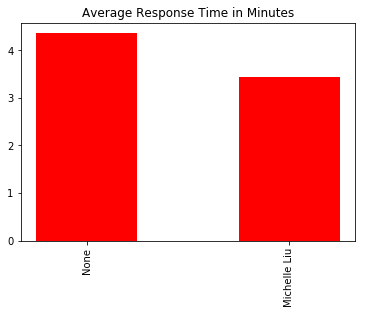

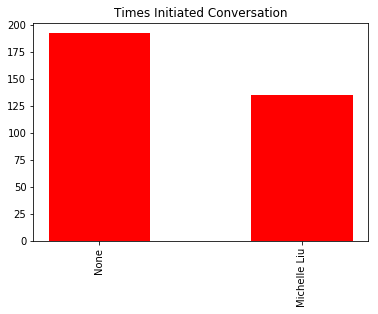

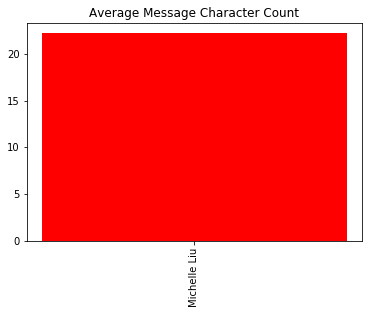

In [48]:
plot(546)